In [27]:
from importlib import reload
import LambdaRankHW
import numpy as np
import query
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [ ]:
train_queries = query.load_queries(os.path.normpath('./HP2003/Fold1/train.txt'), 64)
test_queries = query.load_queries(os.path.normpath('./HP2003/Fold1/test.txt'), 64)
val_queries = query.load_queries(os.path.normpath('./HP2003/Fold1/vali.txt'), 64)

In [2]:
%%prun
reload(LambdaRankHW)
n_epochs = 2
measure_type = LambdaRankHW.LISTWISE
num_features = 64
num_folds = 2

res = LambdaRankHW.experiment(n_epochs, measure_type, num_features, num_folds)


Loading train queries
Loading val queries
Creating the S Matrix
input_dim 64 output_dim 1


/home/jgalle29/anaconda3/lib/python3.5/site-packages/lasagne/layers/helper.py:212: UserWarning: get_output() was called with unused kwargs:
	dtype
  % "\n\t".join(suggestions))


finished create_iter_functions
Epoch 1 of 2 took 7.606s
training loss:		-41.546822
training mNDCG:		0.832470
validation mNDCG:		0.654300

Loading train queries
Loading val queries
Creating the S Matrix
input_dim 64 output_dim 1


/home/jgalle29/anaconda3/lib/python3.5/site-packages/lasagne/layers/helper.py:212: UserWarning: get_output() was called with unused kwargs:
	dtype
  % "\n\t".join(suggestions))


finished create_iter_functions
Epoch 1 of 2 took 7.752s
training loss:		-43.618038
training mNDCG:		0.768410
validation mNDCG:		0.749176

 

In [3]:
res

{1: [{'number': 1,
   'train_loss': -41.546822,
   'train_mndcg': 0.83246975401701584,
   'val_mndcg': 0.65430018890247177},
  {'number': 2,
   'train_loss': -9.7180862,
   'train_mndcg': 0.83338117788845933,
   'val_mndcg': 0.65532170957335578},
 2: [{'number': 1,
   'train_loss': -43.618038,
   'train_mndcg': 0.76841040076459433,
   'val_mndcg': 0.74917590289986213},
  {'number': 2,
   'train_loss': -10.267927,
   'train_mndcg': 0.7679299174615456,
   'val_mndcg': 0.75881139711045831},
  <LambdaRankHW.LambdaRankHW at 0x7f84fdfb3978>]}

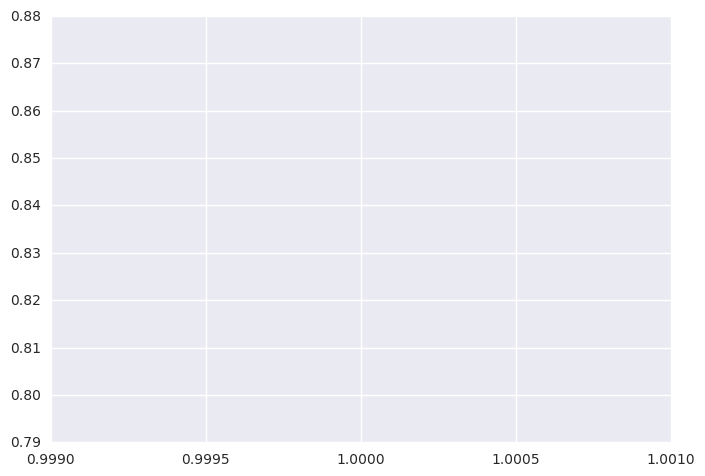

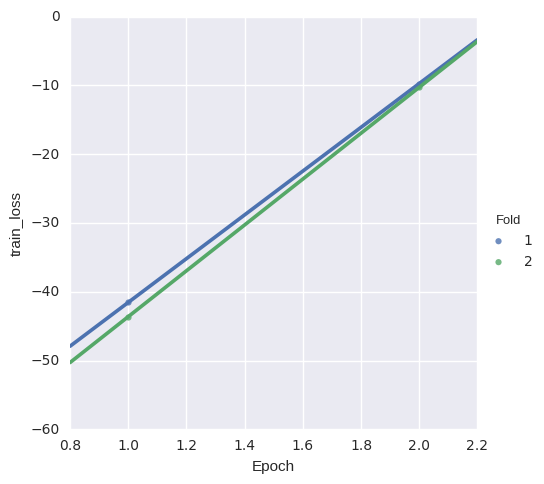

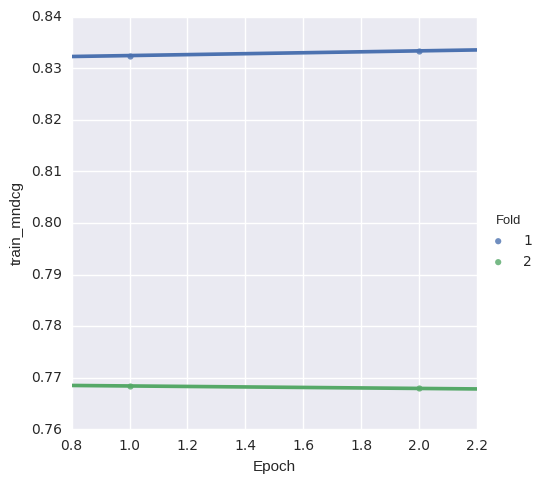

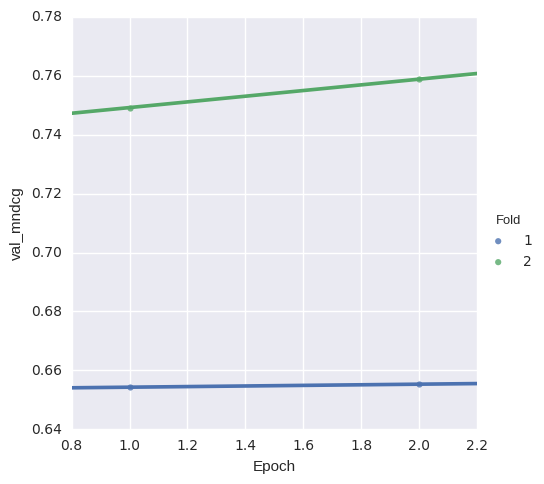

In [111]:
data = []

for fold in res:
    for e_num in range(n_epochs):
        for measure in ['train_loss', 'train_mndcg', 'val_mndcg']:
            epoch_dict = res[fold][e_num]
            aux = [e_num+1, fold, measure, epoch_dict[measure]]
            data.append(aux)

df = pd.DataFrame(data, columns=['Epoch', 'Fold', 'Measure', 'Value'])


for measure in ['train_loss', 'train_mndcg', 'val_mndcg']:
    ax = sns.lmplot(x="Epoch", y="Value", hue="Fold", data= df.loc[df['Measure'] == measure], ci = None)
    ax.set(ylabel=measure)
    plt.show()

#sns.lmplot(x="Epoch", y="Value", hue='Measure', data= df.loc[df['Measure'].isin(['train_mndcg', 'val_mndcg'])], ci = None)
#sns.lmplot(x="Epoch", y="Value", hue="Fold", data= df.loc[df['Measure'].isin(['val_mndcg'])], ci = None)
#ax.set(ylabel=measure)
#plt.show()

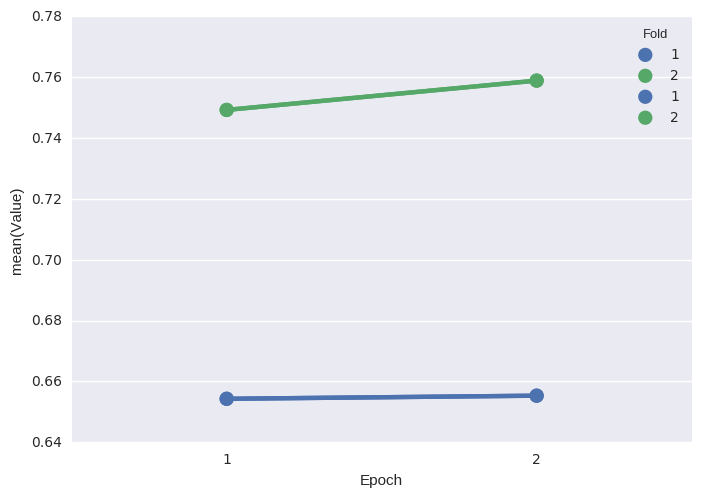

In [113]:

ax = sns.pointplot(x="Epoch", y="Value", hue="Measure", data= df.loc[df['Measure'] == measure], ci = None)
plt.show()

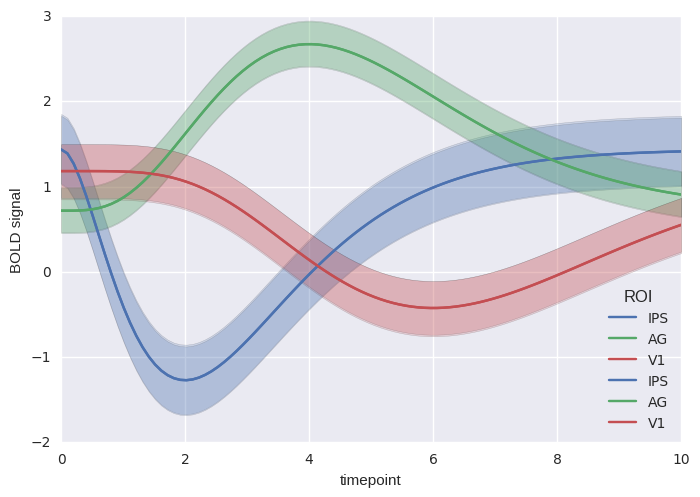

In [59]:
ax = sns.tsplot(time="timepoint", value="BOLD signal",unit="subject", condition="ROI", data=gammas)
plt.show()

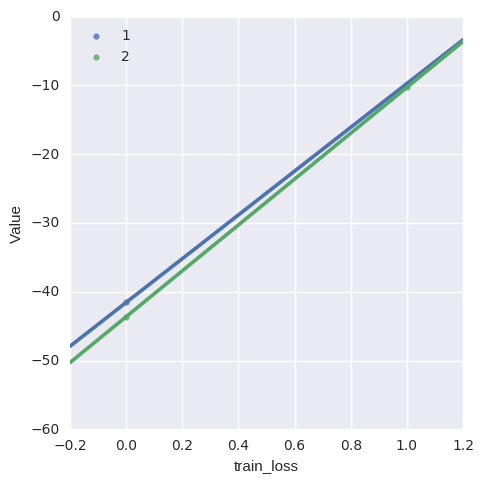

In [78]:
# ax = sns.tsplot(time="Epoch", value="Value", unit="Fold", condition="Measure", data = df.loc[df['Measure'] == 'train_loss'])
# plt.show()

measure = 'train_loss'
ax = sns.lmplot(x="Epoch", y="Value", hue="Fold", data= df.loc[df['Measure'] == measure], ci = None, legend_out=False)
ax.set(xlabel=measure)
ax.despine(left=True)
plt.legend(loc='upper left')
plt.show()

In [60]:
gammas = sns.load_dataset("gammas")

gammas

,timepoint,ROI,subject,BOLD signal
0,0.0,IPS,0,0.513433
1,0.0,IPS,1,-0.414368
2,0.0,IPS,2,0.214695
3,0.0,IPS,3,0.814809
4,0.0,IPS,4,-0.894992
5,0.0,IPS,5,-0.073709
6,0.0,IPS,6,3.542734
7,0.0,IPS,7,0.080169
8,0.0,IPS,8,1.547083
9,0.0,IPS,9,2.827153


In [ ]:
valndcgs = [[rr['val_mndcg'] for rr in res[i][:-1]] for i in res]  
trainndcgs = [[rr['train_mndcg'] for rr in res[i][:-1]] for i in res]  

df = pd.DataFrame(valndcgs, index=['Val Fold%d' % d for d in range(1, num_folds + 1)]).T
plt.plot(df)
df2 = pd.DataFrame(trainndcgs, index=['Train Fold%d' % d for d in range(1, num_folds + 1)]).T
plt.plot(df2)
plt.legend(df2.columns + df.columns)
plt.show()

In [5]:
# Calculates the best NDCG@k for query with r relevant documents and binary relevance labels
def best_ndcg(r, k):
    if r == 0:
        raise ZeroDivisionError("No relevant documents for given query. NDCG can not be computed.")
    sum_limit = min(r, k)
    b_rank = 1 / np.log(1 + np.array(range(1, sum_limit + 1)))
    return b_rank, np.cumsum(b_rank, axis=0)

# Store the logarithmic discount and normalization factor lists for faster NDCG computation
disc_list, norm_list = best_ndcg(1000,1000)
disc_list = disc_list#.reshape((-1,1))

# Calculates the NDCG@k for a rank with binary relevance labels assuming a query with r relevant documents
def ndcg(rank, k, r = 1):
    if r == 0:
        #raise ZeroDivisionError("No relevant documents for given query. NDCG can not be computed.")
        return 0
    return np.transpose(rank[:k]).dot(disc_list[:k]) / norm_list[r-1]


In [10]:
print(np.cumsum(disc_list)[:10])
print(norm_list[:10])

[ 1.44269504  2.35293427  3.07428179  3.69561672  4.25372735  4.76762569
  5.24852404  5.70364365  6.13793813  6.55497053]
[ 1.44269504  2.35293427  3.07428179  3.69561672  4.25372735  4.76762569
  5.24852404  5.70364365  6.13793813  6.55497053]


In [3]:
def delta_ndcdg(i, j, id_i, id_j, labels):
    return (2**labels[id_i] - 2**labels[id_j]) * (disc_list[j] - disc_list[i]) / norm_list[int(np.sum(labels))-1]

In [7]:
doc_ids = np.array(range(1,1001))
labels =np.ones(1000)
scores =np.random.random(1000)
w = 1
l = 2

def meh():
    order = np.argsort(-scores)
    ordered_ids = doc_ids[order]
    # print(order)
    # print(ordered_ids)
    delta_val = np.abs(delta_ndcdg(np.where(ordered_ids == w)[0], np.where(ordered_ids == l)[0], w, l, labels))

%timeit meh ()   

r1 = np.array(labels)[order]
r2 = np.array(labels)[order]
aux = r2[np.where(ordered_ids == w)[0]]
r2[np.where(ordered_ids == w)[0]] = r2[np.where(ordered_ids == l)[0]]
r2[np.where(ordered_ids == l)[0]] = aux
diff = np.abs(ndcg(r2, len(labels), sum(labels)) - ndcg(r1,len(labels),sum(labels)))
# if (diff != delta_val):
print(delta_val, diff)

The slowest run took 6.52 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 56.6 µs per loop


C:\Users\Dana\Anaconda3\lib\site-packages\ipykernel\__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


NameError: name 'delta_val' is not defined

![Kernels](img/kernels.png)